In [1]:
from data import wiki
from data import corpus
import alignment

import nltk
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm_notebook as tqdm
from IPython.display import display, clear_output

tqdm().pandas()

markers = alignment.load_markers()
markers_list = list(markers)

posts = wiki.load_posts()
posts = corpus.tokenize_posts(posts, lower_case=True, overwrite=False)
posts = corpus.detect_markers(posts, markers, overwrite=False)

pairs = corpus.get_reply_pairs(posts)
users = wiki.load_users(posts=posts)

# wiki.save_posts(posts, overwrite=True)
# wiki.save_users(users, overwrite=True)

/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/corpus.py:17: UserWarning: Posts are already tokenized. Skipping tokenization.
  warnings.warn("Posts are already tokenized. Skipping tokenization.")
/Users/xnobwi/ShareFile/Personal Folders/Research/LASN/lasn/data/corpus.py:63: UserWarning: All marker columns already exist. Skipping marker detection.
  warnings.warn("All marker columns already exist. Skipping marker detection.")


## Baseline marker frequency (by user)

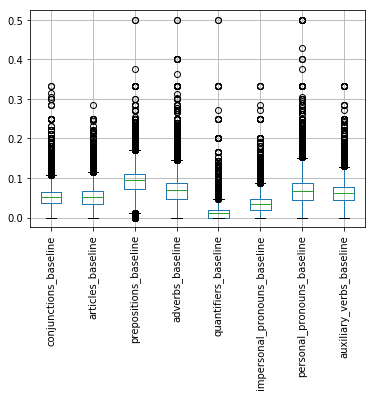

In [2]:
posts['len_tokens'] = posts['tokens'].apply(len)
pairs['len_tokens_b'] = pairs['tokens_b'].apply(len)

user_marker_totals = posts.groupby('user')[['len_tokens'] + list(markers)].sum()
for m in markers:
    users[m + '_baseline'] = user_marker_totals[m] / user_marker_totals['len_tokens']
    pairs = pairs.merge(users[[m+'_baseline']], left_on='user_b', right_index=True)

%matplotlib inline
fig = users.boxplot(column=[m+'_baseline' for m in markers_list], rot=90)

# Surprisal-based alignment

Define the metric

In [3]:
from math import log
from scipy.special import binom

def binom_prob(n,p,k):
    return binom(n,k) * p**k * (1-p)**(n-k)

def binom_surprisal(n,p,k):
    return -log(binom_prob(n,p,k), 2)

def marker_alignment(m, pair, max_len=100):
    """ Function for use with the `pairs` dataframe. """
        
    baseline_freq = pair[m+'_baseline']
    utt_len = pair['len_tokens_b']
    m_count = pair[m+'_b']
    m_freq = m_count / utt_len
    expected = baseline_freq * utt_len
    
    if utt_len > max_len:
        return None
    
    if not pair[m+'_a']: # measure is only defined where `a` exhibits the marker
        return None
    
    polarity = 1 if m_count >= expected else -1
    return polarity * binom_surprisal(utt_len, baseline_freq, m_count)

Compute alignment for each post

In [4]:
for m in tqdm(markers):
    pairs[m + '_align'] = pairs.progress_apply(lambda x: marker_alignment(m, x), axis=1)
clear_output()

Display alignment distributios. Note: Counts indicate the number of posts for which the metric is defined. It is defined for replies where the head post contained the marker and the baseline is defined for the user. There are 172,763 posts total.

,conjunctions_align,articles_align,prepositions_align,adverbs_align,quantifiers_align,impersonal_pronouns_align,personal_pronouns_align,auxiliary_verbs_align
count,117277.000000,114785.000000,128089.000000,122320.000000,66767.000000,104239.000000,124702.000000,121835.000000
mean,0.066368,0.115092,-0.090061,0.232565,0.434246,0.384180,0.444440,0.247554
std,2.348320,2.388373,2.679425,2.767131,1.817110,2.298789,2.773422,2.561187
min,-8.781308,-9.490239,-13.863870,-11.662258,-4.481192,-7.379540,-13.730535,-11.124704
25%,-1.911989,-1.883970,-2.342557,-2.122447,-0.774298,-1.549096,-1.986027,-1.992568
50%,-0.658357,-0.577512,-1.137919,-0.533987,-0.242302,-0.263017,-0.000000,-0.435414
75%,2.244111,2.253658,2.517723,2.553536,1.704194,2.208208,2.590403,2.478800
max,21.148127,15.895608,20.490646,16.584228,15.668516,18.501578,24.437653,13.476151


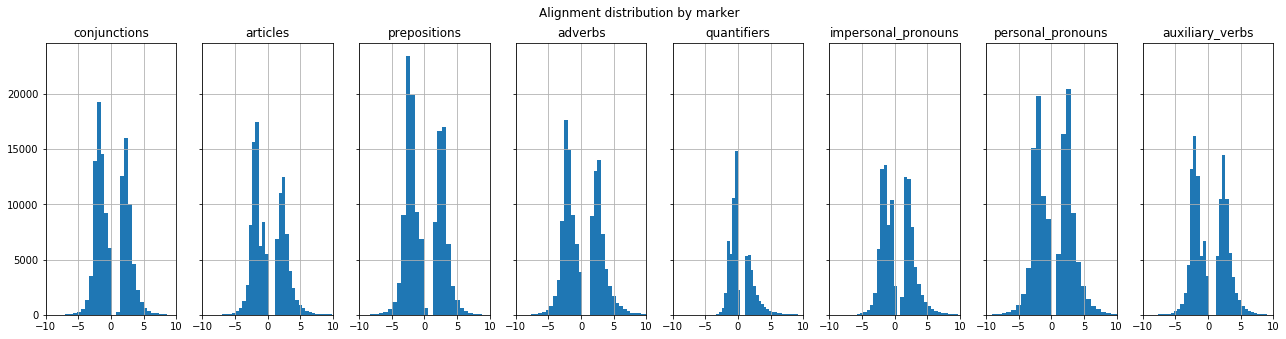

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

display(pairs[[m + '_align' for m in markers_list]].describe())

fig, axes = plt.subplots(nrows=1, ncols=len(markers), sharex=True, sharey=True, figsize=(22,5))
fig.suptitle("Alignment distribution by marker")
for i, m in enumerate(markers):
    axes[i].set_title(m)
    axes[i].set_xlim(-10,10)
    pairs[m+ '_align'].hist(ax=axes[i], bins=50)

## Centrality threshold
Threshold the long-normalized eigenvector centrality. Highly central is >= 1 standard deviation above the mean centrality.

Threshold centrality: 0.8344793851197967


False    29007
True      1893
Name: highly_central, dtype: int64

False    29088
True      1812
Name: admin, dtype: int64

/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/xnobwi/.virtualenvs/lasn/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


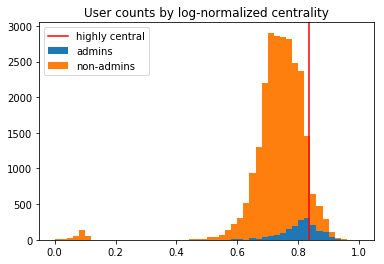

In [6]:
threshold = users.centrality.mean() + users.centrality.std()
users['highly_central'] = (users['centrality'] > threshold)
print("Threshold centrality: {}".format(threshold))
display(users.highly_central.value_counts())
display(users['admin'].value_counts())

admins = np.array([user.centrality for i, user in users[users.admin].iterrows()])
nonadmins = np.array([user.centrality for i, user in users[~users.admin].iterrows()])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([admins,nonadmins], bins=50, stacked=True, label=['admins', 'non-admins'])
plt.axvline(x=threshold, color='r', label="highly central")
ax.legend()
ax.set_title('User counts by log-normalized centrality')
display()

In [7]:
df = pairs \
    .merge(users.add_suffix('_a'), how='left', left_on='user_a', right_index=True) \
    .merge(users.add_suffix('_b'), how='left', left_on='user_b', right_index=True)

# Coordination results

## Admins vs. Highly-central

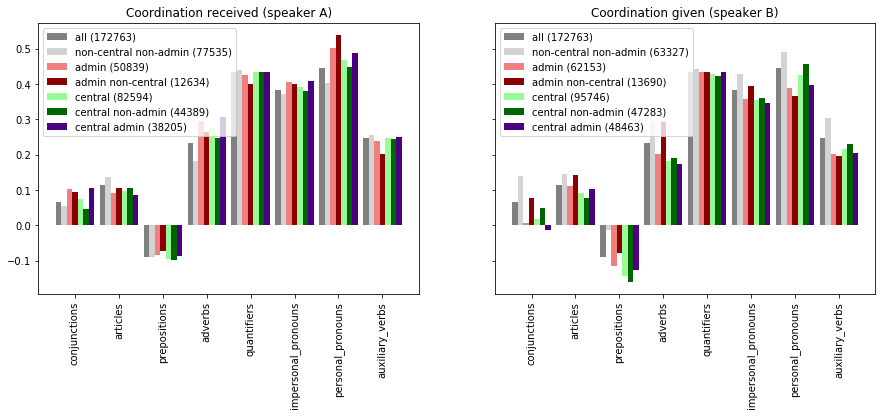

In [8]:
labels = [
    'all',
    'non-central non-admin',
    'admin',
    'admin non-central',
    'central',
    'central non-admin',
    'central admin']

colors = ['gray', 'lightgray', 'lightcoral', 'darkred', 'palegreen', 'darkgreen', 'indigo']


fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,5))
ind = np.arange(len(markers_list))
width = 0.125

titles = ('Coordination received (speaker A)', 'Coordination given (speaker B)')
for ax, s, title in zip(axs, ('_a', '_b'), titles):
    groups = [
        [True] * len(df),
        ~df['admin'+s] & ~df['highly_central'+s],
        df['admin'+s],
        df['admin'+s] & ~df['highly_central'+s],
        df['highly_central'+s],
        df['highly_central'+s] & ~df['admin'+s],
        df['admin'+s] & df['highly_central'+s]]
    p = []
    for i, group in enumerate(groups):
        means = df[group][[m+ '_align' for m in markers_list]].mean()
        p.append(ax.bar(ind+i*width, list(means), width=width, color=colors[i]))
    legend = [l+ ' ({})'.format(len(df[group])) for group,l in zip(groups,labels)]
    ax.legend((p[i][0] for i in range(len(p))), legend)
    ax.set_title(title)
    ax.set_xticklabels(markers_list)
    ax.set_xticks(ind+3*width)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

Left: dreplication of figures 1 & 2 from Noble & Fernandez, 2015 (with additional classes of users) -- measures the propensity of users to coordinate with users of that group

Right: Same thing, but where the varibale is who is speaking -- measures the group's propensity to coordinate in their replies

## Correlation between alignment and speaker A centrality

In [9]:
for m in markers_list:
    corr = df['centrality_a'].corr(df[m+'_align'])
    print('{:20}: {: .5f}'.format(m, corr))

conjunctions        : -0.00146
articles            : -0.01045
prepositions        : -0.00881
adverbs             :  0.01216
quantifiers         :  0.00360
impersonal_pronouns :  0.00396
personal_pronouns   :  0.00845
auxiliary_verbs     : -0.00250
